Напишем реализацию алгоритма [Neural Style Transfer](https://arxiv.org/pdf/1508.06576.pdf)

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import config

## Подготовка

Для начала напишем функции, которые подготавливают картинки к работе модели - выравнивают их по размеру и преобразуют в тензор. И обратную функцию, которая преобразует тензор в картинку.

In [4]:
image_to_tensor = transforms.Compose([transforms.Resize(config.IMAGE_SIZE), transforms.ToTensor()])
tensor_to_image = transforms.ToPILImage()

def path_to_tensor(path):
    image = Image.open(path)
    image = image_to_tensor(image).unsqueeze(0)
    return image.to(torch.float)


def tensor_to_pil_image(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    return tensor_to_image(image)

Проверим правильность работы функций:

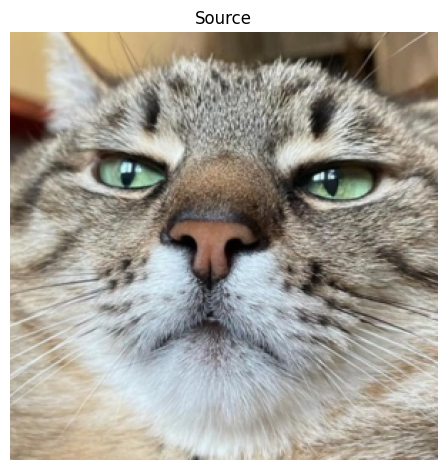

In [5]:
content_img = path_to_tensor("./data/cat2.jpg")
content = tensor_to_pil_image(content_img)

def show_pic(fig, pil, title):
    fig.imshow(pil)
    fig.axis('off')
    fig.set_title(title)

_, axes = plt.subplots(nrows=1, ncols=1)
show_pic(axes, content, "Source")
plt.tight_layout()
plt.show()

## Функции потерь

Определим функции потери контента и стиля. В случае потери контента - это будет просто среднеквадратичная ошибка между представлениями признаков контента и искомого изображения. В случае стиля - это тоже будет среднеквадратичная ошибка но от матриц Грама. Общая ошибка будет считаться по формуле $\alpha CL + \beta SL$, где отношение $\cfrac{\alpha}{\beta} = 10^{-6}$

In [6]:
class ContentLoss(nn.Module):
    def init(self, target):
        super(ContentLoss, self).init()
        self.loss = None
        self.target = target.detach()

    def forward(self, ipt):
        # Вычисляем потерю среднего квадрата между входным изображением и целевым изображением
        self.loss = functional.mse_loss(ipt, self.target)
        return ipt

def gram_matrix(ipt):
    # Вычисляем матрицу Грама для тензора изображения
    b, c, w, h = ipt.size()
    features = ipt.view(b * c, w * h)
    gram = torch.mm(features, features.t())
    return gram.div(b * c * w * h)

class StyleLoss(nn.Module):
    def init(self, target):
        super(StyleLoss, self).init()
        self.loss = None
        self.target = gram_matrix(target).detach()

    def forward(self, ipt):
        # Вычисляем потерю среднего квадрата между граммиановыми матрицами входного и целевого изображений
        gram = gram_matrix(ipt)
        self.loss = functional.mse_loss(gram, self.target)
        return ipt

## Модель!
VGG сеть натренирована на картинках, нормированых на среднее [0.485, 0.456, 0.406] и стандартное отклонение [0.229, 0.224, 0.225]. Сделаем это и мы:

In [7]:
net = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

net_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
net_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 98.0MB/s]


Строим модель, вставляя модули потери контента и стиля сразу после нужных нам слоёв

In [8]:
# Проверяем, находится ли имя слоя в списке имен, и если да, добавляет слой потери к модели
def check_name_and_add_loss_layer(model, name, num, names, img, loss_constr, loss_name, loss_list):
    if name in names:
      # Вычисляем выходные данные модели для данного изображения
      target = model(img).detach()
      # Создаем слой потери, используя конструктор loss_constr
      loss = loss_constr(target)
      # Добавляем слой потери к модели
      model.add_module(loss_name + "{}".format(num), loss)
      # Добавляем слой потери в список loss_list
      loss_list.append(loss)

# Добавляем слой к модели и проверяет, следует ли добавить слой потери для потери контента или стиля
def add_layer(model, name, layer, num, content_losses, style_losses, style_img, content_img):

    # Добавляем слой к модели
    model.add_module(name, layer)
    # Проверяем, следует ли добавить слой потери контента
    check_name_and_add_loss_layer(model, name, num, ['c4'], content_img, ContentLoss, 'cl', content_losses)
    # Проверяем, следует ли добавить слой потери стиля
    check_name_and_add_loss_layer(model, name, num, ['c1', 'c2', 'c3', 'c4', 'c5'], style_img, StyleLoss, 'sl', style_losses)


# Создаем модель для стилевого переноса и возвращает ее вместе со списками слоев потери контента и стиля.
def losses_and_model(cnn, normalization_mean, normalization_std, style_img, content_img):

    content_losses = []
    style_losses = []
    # Создаем модель, состоящую из нормализации и сверточной нейронной сети
    model = nn.Sequential(Normalization(normalization_mean, normalization_std))

    i = 0
    # Перебираем слои в сверточной нейронной сети
    for layer in cnn.children():
        # Если слой - свертка, то увеличиваем номер слоя и обновляем его название
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'c{}'.format(i)
        # Если слой - ReLU, то обновляем его название и делаем inplace=False
        elif isinstance(layer, nn.ReLU):
            name = 'r{}'.format(i)
            layer = nn.ReLU(inplace=False)
        # Если слой не свертка и не ReLU, то название остается 'other'
        else:
            name = 'other'
        # Добавляем слой к модели и проверяем, следует ли добавить слой потери
        add_layer(model, name, layer, i, content_losses, style_losses, style_img, content_img)

    # Находим последний слой потери в модели
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    # Обрезаем модель до последнего слоя потери
    model = model[:(i + 1)]
    # Возвращаем модель и списки слоев потери
    return model, style_losses, content_losses

## Минимизация ошибки
Минимизировать ошибку будем с помощью LBFGS из optim. Пишем спуск:

In [9]:
# общая потеря по списку потерь
def lsum(losses):
    result = 0
    for l in losses:
        result += l.loss
    return result

# нейронный стиль переноса
def nst(cnn, normalization_mean, normalization_std, content_img, style_img, input_img):

    # Вычисляем потери стиля и контента и получаем модель из предварительно обученной CNN
    model, style_losses, content_losses = (
        losses_and_model(cnn, normalization_mean, normalization_std, style_img, content_img))

    # Делаем изображение ввода требующим градиента
    input_img.requires_grad_(True)

    # Переводим модель в режим оценки, чтобы предотвратить обучение ее параметров
    model.eval()

    # Делаем модель не требующей градиента, чтобы избежать обновления ее параметров
    model.requires_grad_(False)

    # Создаем оптимизатор для изображения ввода
    optimizer = optim.LBFGS([input_img])

    # Инициализируем счетчик шагов
    run = [0]

    # Оптимизируем
    while run[0] <= config.STEPS:
        # Создаем функцию шага дескриптора для оптимизации изображения ввода
        def des_step():
            # Привязываем градиент изображения ввода к нулю
            with torch.no_grad():
                input_img.clamp_(0, 1)

            # Выполняем прямой проход через модель с изображением ввода
            optimizer.zero_grad()
            model(input_img)

            # Вычисляем потери стиля и контента
            style_score = lsum(style_losses)
            content_score = lsum(content_losses)

            # Вычисляем общую потерю по формуле выше
            loss = style_score * config.STYLE_WEIGHT + content_score * config.CONTENT_WEIGHT
            loss.backward()

            # Увеличиваем счетчик шагов
            run[0] += 1

            # Возвращаем общую потерю
            return style_score + content_score

        # Выполняем шаг оптимизатора.
        optimizer.step(des_step)

    # Привязываем градиент изображения ввода к нулю.
    with torch.no_grad():
        input_img.clamp_(0, 1)

    # Возвращаем изображение с перенесенным стилем.
    return input_img


## Примеры работы

In [10]:
night_img = path_to_tensor("./data/night.jpg")
pasta_img = path_to_tensor("./data/pasta.jpg")
tree_img = path_to_tensor("./data/tree.jpeg")
style_list = [night_img, pasta_img, tree_img]

def run_style(stl):
    input_img = content_img.clone()
    result = nst(net, net_normalization_mean, net_normalization_std, content_img, stl, input_img)
    _, axes = plt.subplots(nrows=1, ncols=3)
    show_pic(axes[0], tensor_to_pil_image(content_img), "Content")
    show_pic(axes[1], tensor_to_pil_image(stl), "Style")
    show_pic(axes[2], tensor_to_pil_image(result), "Result")
    plt.tight_layout()
    plt.show()

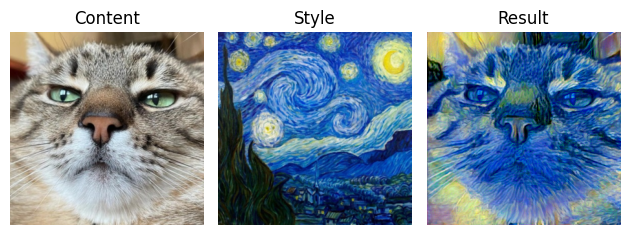

In [11]:
run_style(night_img)

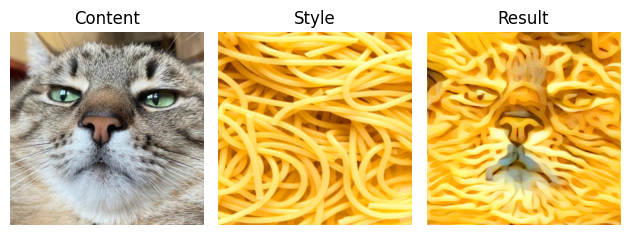

In [12]:
run_style(pasta_img)

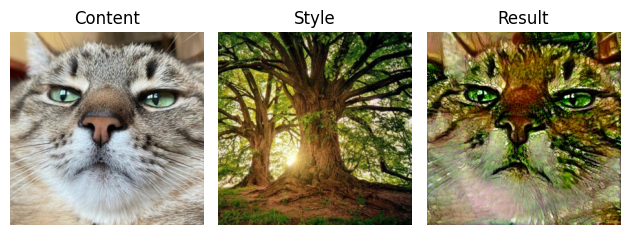

In [13]:
run_style(tree_img)